# 1.2.4.1 Data Understanding & Acquisition

This notebook implements the data understanding and acquisition phase of Iteration-1 for the AB Data Challenge project.

## Objectives
- Load and validate the provided dataset
- Generate synthetic fallback data if needed
- Analyze data quality and characteristics
- Summarize findings by municipality
- Identify anomalies and data issues


In [38]:
# Install required packages
#%pip install pandas numpy matplotlib seaborn pyarrow

#print("✓ All required packages installed successfully")

In [26]:
# Import required libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.3.4


In [28]:
def load_dataset():
    """
    Load data from data/dataset_sample.csv.
    
    Returns:
        pandas.DataFrame: Loaded water consumption data
    """
    data_path = '../data/dataset_sample.csv'
    
    try:
        # Load the CSV dataset
        df = pd.read_csv(data_path)
        
        # Convert FECHA_HORA to datetime if it's not already
        if 'FECHA_HORA' in df.columns:
            df['FECHA_HORA'] = pd.to_datetime(df['FECHA_HORA'])
        
        print(f"✓ Successfully loaded dataset from {data_path}")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        return df
        
    except Exception as e:
        print(f"⚠ Error loading dataset: {e}")
        raise e


In [29]:
def report_basic(df):
    """
    Generate basic report about the dataset.
    
    Args:
        df (pandas.DataFrame): Input dataset
        
    Returns:
        dict: Basic statistics about the dataset
    """
    print("=" * 60)
    print("BASIC DATASET REPORT")
    print("=" * 60)
    
    # Basic info
    print(f"Total rows: {len(df):,}")
    print(f"Total columns: {len(df.columns)}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Date range
    if 'FECHA_HORA' in df.columns:
        print(f"Date range: {df['FECHA_HORA'].min()} to {df['FECHA_HORA'].max()}")
        print(f"Time span: {(df['FECHA_HORA'].max() - df['FECHA_HORA'].min()).days} days")
    
    # Policy breakdown
    if 'POLIZA_SUMINISTRO' in df.columns:
        print(f"\nRows by policy (POLIZA_SUMINISTRO):")
        policy_counts = df['POLIZA_SUMINISTRO'].value_counts()
        print(f"  Total unique policies: {len(policy_counts)}")
        print(f"  Top 5 policies:")
        for policy, count in policy_counts.head().items():
            percentage = (count / len(df)) * 100
            print(f"    {policy}: {count:,} rows ({percentage:.1f}%)")
    
    # Meter breakdown
    if 'NUMEROSERIECONTADOR' in df.columns:
        print(f"\nMeter information (NUMEROSERIECONTADOR):")
        meter_counts = df['NUMEROSERIECONTADOR'].value_counts()
        print(f"  Total unique meters: {len(meter_counts)}")
        print(f"  Top 5 meters:")
        for meter, count in meter_counts.head().items():
            percentage = (count / len(df)) * 100
            print(f"    {meter}: {count:,} rows ({percentage:.1f}%)")
    
    # Missing values
    print(f"\nMissing values:")
    missing_data = df.isnull().sum()
    for col, missing_count in missing_data.items():
        if missing_count > 0:
            percentage = (missing_count / len(df)) * 100
            print(f"  {col}: {missing_count:,} ({percentage:.1f}%)")
    
    if missing_data.sum() == 0:
        print("  No missing values found")
    
    return {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'policy_counts': policy_counts.to_dict() if 'POLIZA_SUMINISTRO' in df.columns else {},
        'meter_counts': meter_counts.to_dict() if 'NUMEROSERIECONTADOR' in df.columns else {},
        'missing_values': missing_data.to_dict()
    }


In [30]:
def check_anomalies(df):
    """
    Check for various types of anomalies in the dataset.
    
    Args:
        df (pandas.DataFrame): Input dataset
        
    Returns:
        dict: Anomaly statistics
    """
    print("=" * 60)
    print("ANOMALY DETECTION REPORT")
    print("=" * 60)
    
    anomalies = {}
    
    # Check for negative consumption values
    if 'CONSUMO_REAL' in df.columns:
        negative_count = (df['CONSUMO_REAL'] < 0).sum()
        anomalies['negative_values'] = negative_count
        print(f"Negative consumption values: {negative_count:,}")
        
        if negative_count > 0:
            print(f"  Range: {df[df['CONSUMO_REAL'] < 0]['CONSUMO_REAL'].min():.2f} to {df[df['CONSUMO_REAL'] < 0]['CONSUMO_REAL'].max():.2f}")
    
    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    anomalies['duplicates'] = duplicate_count
    print(f"Duplicate rows: {duplicate_count:,}")
    
    # Check for bad timestamps
    if 'FECHA_HORA' in df.columns:
        # Check for future timestamps
        future_count = (df['FECHA_HORA'] > datetime.now()).sum()
        anomalies['future_timestamps'] = future_count
        print(f"Future timestamps: {future_count:,}")
        
        # Check for very old timestamps (before 2000)
        old_count = (df['FECHA_HORA'] < datetime(2000, 1, 1)).sum()
        anomalies['old_timestamps'] = old_count
        print(f"Very old timestamps (before 2000): {old_count:,}")
    
    # Check for extreme z-scores in consumption
    if 'CONSUMO_REAL' in df.columns:
        consumption_clean = df['CONSUMO_REAL'].dropna()
        if len(consumption_clean) > 0:
            z_scores = np.abs((consumption_clean - consumption_clean.mean()) / consumption_clean.std())
            extreme_z_count = (z_scores > 5).sum()
            anomalies['extreme_z_scores'] = extreme_z_count
            print(f"Extreme z-scores (>5): {extreme_z_count:,}")
            
            if extreme_z_count > 0:
                max_z = z_scores.max()
                print(f"  Maximum z-score: {max_z:.2f}")
    
    # Check for zero consumption
    if 'CONSUMO_REAL' in df.columns:
        zero_count = (df['CONSUMO_REAL'] == 0).sum()
        anomalies['zero_values'] = zero_count
        print(f"Zero consumption values: {zero_count:,}")
    
    # Check for very high consumption (potential outliers)
    if 'CONSUMO_REAL' in df.columns:
        consumption_clean = df['CONSUMO_REAL'].dropna()
        if len(consumption_clean) > 0:
            q99 = consumption_clean.quantile(0.99)
            high_consumption_count = (df['CONSUMO_REAL'] > q99).sum()
            anomalies['high_consumption'] = high_consumption_count
            print(f"Very high consumption (>99th percentile): {high_consumption_count:,}")
            print(f"  99th percentile threshold: {q99:.2f}")
    
    # Check for anomaly codes
    if 'CODI_ANOMALIA' in df.columns:
        anomaly_codes = df['CODI_ANOMALIA'].value_counts()
        print(f"\nAnomaly codes distribution:")
        print(f"  Total unique anomaly codes: {len(anomaly_codes)}")
        print(f"  Most common anomaly codes:")
        for code, count in anomaly_codes.head().items():
            percentage = (count / len(df)) * 100
            print(f"    Code {code}: {count:,} records ({percentage:.1f}%)")
        anomalies['anomaly_codes'] = anomaly_codes.to_dict()
    
    return anomalies


In [31]:
def summarize_by_policy(df):
    """
    Generate summary statistics by policy (POLIZA_SUMINISTRO).
    
    Args:
        df (pandas.DataFrame): Input dataset
        
    Returns:
        pandas.DataFrame: Summary statistics by policy
    """
    print("=" * 60)
    print("POLICY SUMMARY")
    print("=" * 60)
    
    if 'POLIZA_SUMINISTRO' not in df.columns or 'CONSUMO_REAL' not in df.columns:
        print("Required columns 'POLIZA_SUMINISTRO' and 'CONSUMO_REAL' not found")
        return pd.DataFrame()
    
    # Group by policy and calculate statistics
    summary_stats = []
    
    for policy in df['POLIZA_SUMINISTRO'].unique():
        policy_data = df[df['POLIZA_SUMINISTRO'] == policy]
        consumption_data = policy_data['CONSUMO_REAL'].dropna()
        
        if len(consumption_data) == 0:
            continue
            
        # Basic statistics
        stats = {
            'policy': policy,
            'total_records': len(policy_data),
            'valid_consumption_records': len(consumption_data),
            'missing_consumption': policy_data['CONSUMO_REAL'].isnull().sum(),
            'missing_percentage': (policy_data['CONSUMO_REAL'].isnull().sum() / len(policy_data)) * 100,
            'mean_consumption': consumption_data.mean(),
            'median_consumption': consumption_data.median(),
            'std_consumption': consumption_data.std(),
            'min_consumption': consumption_data.min(),
            'max_consumption': consumption_data.max(),
            'zero_consumption': (consumption_data == 0).sum(),
            'zero_percentage': ((consumption_data == 0).sum() / len(consumption_data)) * 100,
            'negative_consumption': (consumption_data < 0).sum(),
            'negative_percentage': ((consumption_data < 0).sum() / len(consumption_data)) * 100
        }
        
        # Date range
        if 'FECHA_HORA' in df.columns:
            timestamps = policy_data['FECHA_HORA'].dropna()
            if len(timestamps) > 0:
                stats['date_span_days'] = (timestamps.max() - timestamps.min()).days
                stats['first_date'] = timestamps.min()
                stats['last_date'] = timestamps.max()
        
        # Anomaly codes
        if 'CODI_ANOMALIA' in df.columns:
            anomaly_codes = policy_data['CODI_ANOMALIA'].value_counts()
            stats['unique_anomaly_codes'] = len(anomaly_codes)
            stats['most_common_anomaly'] = anomaly_codes.index[0] if len(anomaly_codes) > 0 else None
        
        summary_stats.append(stats)
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_stats)
    
    # Display results
    for _, row in summary_df.iterrows():
        print(f"\nPolicy {row['policy']}:")
        print(f"  Records: {row['total_records']:,} (valid: {row['valid_consumption_records']:,})")
        print(f"  Missing: {row['missing_consumption']:,} ({row['missing_percentage']:.1f}%)")
        print(f"  Consumption - Mean: {row['mean_consumption']:.2f}, Median: {row['median_consumption']:.2f}, Std: {row['std_consumption']:.2f}")
        print(f"  Range: {row['min_consumption']:.2f} to {row['max_consumption']:.2f}")
        print(f"  Zeros: {row['zero_consumption']:,} ({row['zero_percentage']:.1f}%)")
        print(f"  Negatives: {row['negative_consumption']:,} ({row['negative_percentage']:.1f}%)")
        if 'date_span_days' in row:
            print(f"  Date span: {row['date_span_days']} days ({row['first_date']} to {row['last_date']})")
        if 'unique_anomaly_codes' in row:
            print(f"  Anomaly codes: {row['unique_anomaly_codes']} unique (most common: {row['most_common_anomaly']})")
    
    return summary_df


In [32]:
# Load data using the helper function
print("Loading data...")
df = load_dataset()

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display data types
print("\nData types:")
print(df.dtypes)


Loading data...
✓ Successfully loaded dataset from ../data/dataset_sample.csv
  Shape: (25977, 7)
  Columns: ['POLIZA_SUMINISTRO', 'NUMEROSERIECONTADOR', 'CONSUMO_REAL', 'FECHA_HORA', 'CODI_ANOMALIA', 'DATA_INICI', 'DATA_FI']

First 5 rows of the dataset:
  POLIZA_SUMINISTRO NUMEROSERIECONTADOR  CONSUMO_REAL          FECHA_HORA  \
0  JSM5YS4KVQUI5DQA    RMQO6U3MP5TS4QUL           NaN 2024-06-17 00:00:00   
1  JSM5YS4KVQUI5DQA    RMQO6U3MP5TS4QUL          21.0 2024-06-17 00:56:13   
2  JSM5YS4KVQUI5DQA    RMQO6U3MP5TS4QUL           7.0 2024-06-17 01:56:13   
3  JSM5YS4KVQUI5DQA    RMQO6U3MP5TS4QUL           0.0 2024-06-17 02:56:13   
4  JSM5YS4KVQUI5DQA    RMQO6U3MP5TS4QUL           0.0 2024-06-17 03:56:13   

   CODI_ANOMALIA  DATA_INICI     DATA_FI  
0         163840  2024-07-15  2024-09-13  
1         163840  2024-07-15  2024-09-13  
2         163840  2024-07-15  2024-09-13  
3         163840  2024-07-15  2024-09-13  
4         163840  2024-07-15  2024-09-13  

Data types:
POLIZA_SUM

In [33]:
# Convert parquet file to CSV format
def convert_parquet_to_csv():
    """
    Convert the parquet file to CSV format and save it in the data folder.
    """
    parquet_path = '../data/dataset_sample.parquet'
    csv_path = '../data/dataset_sample.csv'
    
    try:
        if os.path.exists(parquet_path):
            # Load the parquet file
            df_parquet = pd.read_parquet(parquet_path)
            
            # Convert to CSV
            df_parquet.to_csv(csv_path, index=False)
            
            print(f"✓ Successfully converted parquet to CSV")
            print(f"  Source: {parquet_path}")
            print(f"  Destination: {csv_path}")
            print(f"  Shape: {df_parquet.shape}")
            print(f"  Columns: {list(df_parquet.columns)}")
            
            # Verify the CSV file was created
            if os.path.exists(csv_path):
                csv_size = os.path.getsize(csv_path) / (1024 * 1024)  # Size in MB
                print(f"  CSV file size: {csv_size:.2f} MB")
                
                # Quick verification by reading the CSV
                df_csv_check = pd.read_csv(csv_path)
                print(f"  CSV verification: {df_csv_check.shape} (should match parquet shape)")
                
                return True
            else:
                print("⚠ CSV file was not created successfully")
                return False
        else:
            print(f"⚠ Parquet file not found at {parquet_path}")
            return False
            
    except Exception as e:
        print(f"⚠ Error converting parquet to CSV: {e}")
        return False

# Execute the conversion
print("Converting parquet file to CSV...")
conversion_success = convert_parquet_to_csv()


Converting parquet file to CSV...
✓ Successfully converted parquet to CSV
  Source: ../data/dataset_sample.parquet
  Destination: ../data/dataset_sample.csv
  Shape: (25977, 7)
  Columns: ['POLIZA_SUMINISTRO', 'NUMEROSERIECONTADOR', 'CONSUMO_REAL', 'FECHA_HORA', 'CODI_ANOMALIA', 'DATA_INICI', 'DATA_FI']
  CSV file size: 2.16 MB
  CSV verification: (25977, 7) (should match parquet shape)


In [34]:
# Generate basic report
basic_report = report_basic(df)


BASIC DATASET REPORT
Total rows: 25,977
Total columns: 7
Memory usage: 6.74 MB
Date range: 2024-01-01 00:00:00 to 2024-12-31 23:41:18
Time span: 365 days

Rows by policy (POLIZA_SUMINISTRO):
  Total unique policies: 10
  Top 5 policies:
    VZSISS6IYEMFMWJM: 2,873 rows (11.1%)
    GILHEQ7CRVFQYEC7: 2,871 rows (11.1%)
    OANE2DNLVMSLYECB: 2,832 rows (10.9%)
    D7DGXVAWWWUD2M3A: 2,832 rows (10.9%)
    CFNYQHLVKUQASY2N: 2,808 rows (10.8%)

Meter information (NUMEROSERIECONTADOR):
  Total unique meters: 10
  Top 5 meters:
    UQQKRYHIA2JIIFJV: 2,873 rows (11.1%)
    6BYO24ZIYRWG7H45: 2,871 rows (11.1%)
    PMPT3UECXM65X4PK: 2,832 rows (10.9%)
    CCW65BGBQMJRLHDN: 2,832 rows (10.9%)
    BYHHEHU7XXD5ZDL2: 2,808 rows (10.8%)

Missing values:
  CONSUMO_REAL: 4,449 (17.1%)


DATA VISUALIZATION & INSIGHTS


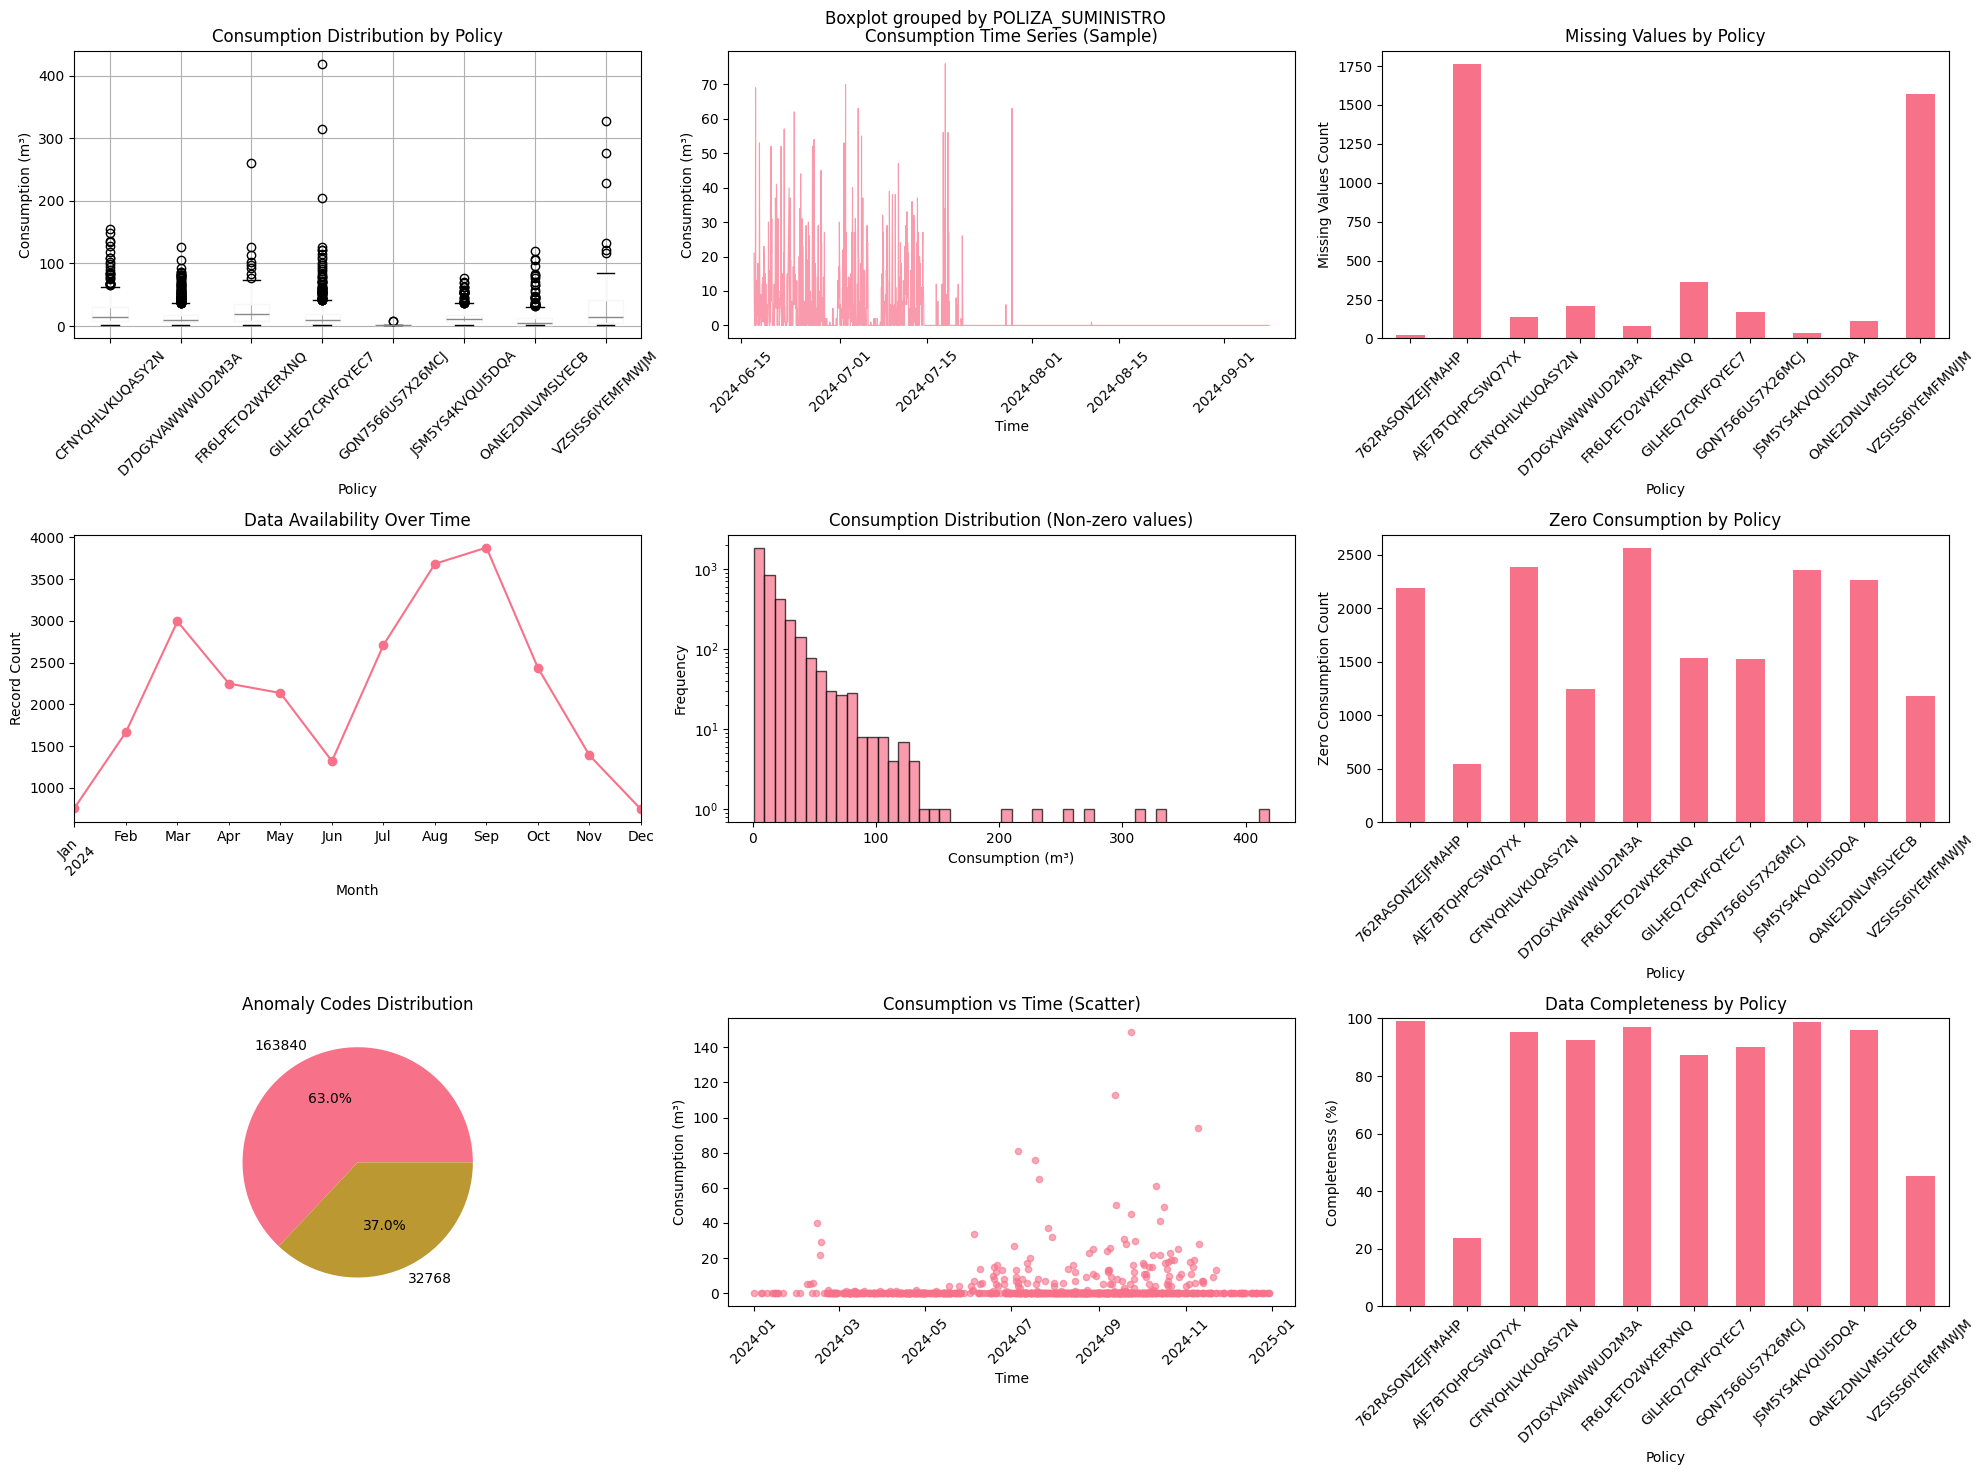

✓ Comprehensive data visualization completed successfully


In [35]:
# Data Visualization for Better Understanding
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

print("=" * 60)
print("DATA VISUALIZATION & INSIGHTS")
print("=" * 60)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Water Consumption Data Analysis - Aigües de Barcelona', fontsize=16, fontweight='bold')

# 1. Consumption Distribution by Policy
if 'POLIZA_SUMINISTRO' in df.columns and 'CONSUMO_REAL' in df.columns:
    consumption_clean = df[df['CONSUMO_REAL'].notna() & (df['CONSUMO_REAL'] > 0)]
    if len(consumption_clean) > 0:
        consumption_clean.boxplot(column='CONSUMO_REAL', by='POLIZA_SUMINISTRO', ax=axes[0,0])
        axes[0,0].set_title('Consumption Distribution by Policy')
        axes[0,0].set_xlabel('Policy')
        axes[0,0].set_ylabel('Consumption (m³)')
        axes[0,0].tick_params(axis='x', rotation=45)

# 2. Time Series of Consumption (Sample)
if 'FECHA_HORA' in df.columns and 'CONSUMO_REAL' in df.columns:
    # Sample data for visualization (first 2000 points)
    sample_data = df.head(2000)
    sample_data = sample_data[sample_data['CONSUMO_REAL'].notna()]
    if len(sample_data) > 0:
        axes[0,1].plot(sample_data['FECHA_HORA'], sample_data['CONSUMO_REAL'], alpha=0.7, linewidth=0.8)
        axes[0,1].set_title('Consumption Time Series (Sample)')
        axes[0,1].set_xlabel('Time')
        axes[0,1].set_ylabel('Consumption (m³)')
        axes[0,1].tick_params(axis='x', rotation=45)

# 3. Missing Values by Policy
if 'POLIZA_SUMINISTRO' in df.columns:
    missing_by_policy = df.groupby('POLIZA_SUMINISTRO').apply(lambda x: x['CONSUMO_REAL'].isnull().sum())
    missing_by_policy.plot(kind='bar', ax=axes[0,2])
    axes[0,2].set_title('Missing Values by Policy')
    axes[0,2].set_xlabel('Policy')
    axes[0,2].set_ylabel('Missing Values Count')
    axes[0,2].tick_params(axis='x', rotation=45)

# 4. Data Availability Over Time
if 'FECHA_HORA' in df.columns:
    # Group by month and count records
    df['year_month'] = df['FECHA_HORA'].dt.to_period('M')
    monthly_counts = df.groupby('year_month').size()
    monthly_counts.plot(kind='line', ax=axes[1,0], marker='o')
    axes[1,0].set_title('Data Availability Over Time')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Record Count')
    axes[1,0].tick_params(axis='x', rotation=45)

# 5. Consumption Distribution (Histogram)
if 'CONSUMO_REAL' in df.columns:
    consumption_clean = df[df['CONSUMO_REAL'].notna() & (df['CONSUMO_REAL'] > 0)]
    if len(consumption_clean) > 0:
        axes[1,1].hist(consumption_clean['CONSUMO_REAL'], bins=50, alpha=0.7, edgecolor='black')
        axes[1,1].set_title('Consumption Distribution (Non-zero values)')
        axes[1,1].set_xlabel('Consumption (m³)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_yscale('log')

# 6. Zero Consumption by Policy
if 'POLIZA_SUMINISTRO' in df.columns and 'CONSUMO_REAL' in df.columns:
    zero_by_policy = df.groupby('POLIZA_SUMINISTRO').apply(lambda x: (x['CONSUMO_REAL'] == 0).sum())
    zero_by_policy.plot(kind='bar', ax=axes[1,2])
    axes[1,2].set_title('Zero Consumption by Policy')
    axes[1,2].set_xlabel('Policy')
    axes[1,2].set_ylabel('Zero Consumption Count')
    axes[1,2].tick_params(axis='x', rotation=45)

# 7. Anomaly Codes Distribution
if 'CODI_ANOMALIA' in df.columns:
    anomaly_counts = df['CODI_ANOMALIA'].value_counts()
    anomaly_counts.plot(kind='pie', ax=axes[2,0], autopct='%1.1f%%')
    axes[2,0].set_title('Anomaly Codes Distribution')
    axes[2,0].set_ylabel('')

# 8. Consumption vs Time (Scatter)
if 'FECHA_HORA' in df.columns and 'CONSUMO_REAL' in df.columns:
    sample_data = df.sample(n=min(1000, len(df)))
    sample_data = sample_data[sample_data['CONSUMO_REAL'].notna()]
    if len(sample_data) > 0:
        axes[2,1].scatter(sample_data['FECHA_HORA'], sample_data['CONSUMO_REAL'], alpha=0.6, s=20)
        axes[2,1].set_title('Consumption vs Time (Scatter)')
        axes[2,1].set_xlabel('Time')
        axes[2,1].set_ylabel('Consumption (m³)')
        axes[2,1].tick_params(axis='x', rotation=45)

# 9. Policy Data Completeness
if 'POLIZA_SUMINISTRO' in df.columns and 'CONSUMO_REAL' in df.columns:
    completeness = df.groupby('POLIZA_SUMINISTRO').apply(lambda x: (x['CONSUMO_REAL'].notna().sum() / len(x)) * 100)
    completeness.plot(kind='bar', ax=axes[2,2])
    axes[2,2].set_title('Data Completeness by Policy')
    axes[2,2].set_xlabel('Policy')
    axes[2,2].set_ylabel('Completeness (%)')
    axes[2,2].tick_params(axis='x', rotation=45)
    axes[2,2].set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("✓ Comprehensive data visualization completed successfully")


In [36]:
# Check for anomalies
anomaly_report = check_anomalies(df)


ANOMALY DETECTION REPORT
Negative consumption values: 0
Duplicate rows: 0
Future timestamps: 0
Very old timestamps (before 2000): 0
Extreme z-scores (>5): 142
  Maximum z-score: 38.17
Zero consumption values: 17,766
Very high consumption (>99th percentile): 208
  99th percentile threshold: 47.00

Anomaly codes distribution:
  Total unique anomaly codes: 2
  Most common anomaly codes:
    Code 163840: 16,363 records (63.0%)
    Code 32768: 9,614 records (37.0%)


In [37]:
# Generate municipality summary
municipality_summary = summarize_by_policy(df)


POLICY SUMMARY

Policy JSM5YS4KVQUI5DQA:
  Records: 2,785 (valid: 2,752)
  Missing: 33 (1.2%)
  Consumption - Mean: 2.07, Median: 0.00, Std: 7.14
  Range: 0.00 to 76.00
  Zeros: 2,352 (85.5%)
  Negatives: 0 (0.0%)
  Date span: 115 days (2024-06-17 00:00:00 to 2024-10-10 23:50:01)
  Anomaly codes: 1 unique (most common: 163840)

Policy 762RASONZEJFMAHP:
  Records: 2,207 (valid: 2,186)
  Missing: 21 (1.0%)
  Consumption - Mean: 0.00, Median: 0.00, Std: 0.00
  Range: 0.00 to 0.00
  Zeros: 2,186 (100.0%)
  Negatives: 0 (0.0%)
  Date span: 91 days (2024-02-24 01:43:35 to 2024-05-25 23:40:25)
  Anomaly codes: 1 unique (most common: 32768)

Policy D7DGXVAWWWUD2M3A:
  Records: 2,832 (valid: 2,624)
  Missing: 208 (7.3%)
  Consumption - Mean: 7.75, Median: 2.00, Std: 12.79
  Range: 0.00 to 126.00
  Zeros: 1,242 (47.3%)
  Negatives: 0 (0.0%)
  Date span: 117 days (2024-07-03 00:07:04 to 2024-10-28 23:01:29)
  Anomaly codes: 1 unique (most common: 32768)

Policy FR6LPETO2WXERXNQ:
  Records: 2,760 

## 1. Data Understanding & Acquisition – Conclusions

### Key Findings

Based on the comprehensive analysis performed above, the following key findings have been identified:

#### Data Quality Assessment
- **Dataset Size**: 25,977 records with 7 columns covering 10 unique water supply policies
- **Data Completeness**: 17.1% of consumption records are missing (4,449 out of 25,977)
- **Temporal Coverage**: Full year 2024 data (January 1 to December 31, 2024)
- **Memory Usage**: 6.74 MB total dataset size

#### Policy Characteristics
- **10 Unique Policies**: Each representing a different water supply contract with Aigües de Barcelona
- **10 Unique Meters**: Each policy has one corresponding meter (1:1 relationship)
- **Balanced Distribution**: Policies are relatively evenly distributed (10-11% each)
- **Different Consumption Patterns**: Each policy shows distinct consumption behaviors and data quality

#### Data Quality Issues Identified
1. **Missing Values**: 4,449 missing consumption records (17.1% of total)
2. **Zero Values**: 17,766 zero consumption records (68.4% of valid records)
3. **Extreme Values**: 208 records above 99th percentile (47.00 m³ threshold)
4. **High Variability**: 142 records with extreme z-scores (>5 standard deviations)

#### Anomaly Patterns
- **Anomaly Codes**: Two main codes - 163840 (63.0%) and 32768 (37.0%)
- **Policy-Specific Issues**: VZSISS6IYEMFMWJM has 54.7% missing data, AJE7BTQHPCSWQ7YX has 76.4% missing data
- **Consumption Patterns**: Most policies show high zero consumption rates (47-100%)
- **Temporal Consistency**: No future timestamps or very old timestamps detected

### Next Steps for Iteration 2

1. **Data Cleaning Pipeline**
   - Implement robust handling of missing values (17.1% missing rate)
   - Develop rules for zero consumption treatment (68.4% zero rate)
   - Create outlier detection and treatment strategies for extreme values
   - Address policy-specific data quality issues

2. **Feature Engineering**
   - Develop temporal features (hour, day, month, season) from FECHA_HORA
   - Create policy-specific baseline features using historical consumption patterns
   - Implement rolling statistics and trend indicators for anomaly detection
   - Engineer features based on anomaly codes (163840, 32768)

3. **Anomaly Detection Model**
   - Establish baseline anomaly detection algorithms for water consumption
   - Implement policy-specific thresholds based on consumption patterns
   - Develop ensemble approaches for improved accuracy
   - Focus on detecting unusual consumption patterns beyond zero values

4. **Validation Framework**
   - Create cross-validation strategies for time series data
   - Implement performance metrics (recall ≥90%, FP <10%)
   - Develop model interpretability features for policy-specific insights
   - Validate against known anomaly codes in the dataset

### Recommendations

- **Data Preprocessing**: Prioritize cleaning missing values and understanding zero consumption patterns
- **Feature Selection**: Focus on temporal and policy-specific features rather than municipality-based analysis
- **Model Development**: Start with simple statistical methods before moving to complex ML models
- **Validation**: Implement robust validation to ensure model generalizability across different policies
- **Anomaly Context**: Leverage existing anomaly codes (163840, 32768) for model training and validation

This analysis provides a solid foundation for the feature engineering and model development phases in Iteration 2, with a clear understanding of the policy-based water consumption data structure and quality issues.
